In [1]:
# importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from imdb import IMDb, IMDbDataAccessError
from scipy.stats import norm
import torch

In [2]:
# Constants

SPLIT = 0.2
RANDOM_STATE = 13

# 1. Twitter data ananlysis for Sentiment score

In [129]:
pd_genre = pd.read_csv('u.genre', sep= '|', header= None)
pd_genre.head()

,0,1
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [130]:
pd_genre.loc[pd_genre[0] == 'unknown', 0] = 'Unknown'

In [131]:
columns = ['Movie_Id', 'Movie_Title', 'Release_Date', 'Video_Release_Date', 'IMDB_Url'] + pd_genre[0].to_list()

In [132]:
pd_item = pd.read_csv('u.item', sep= '|', encoding='ISO-8859-1', header= None, names= columns)

In [133]:
pd_item.head()

,Movie_Id,Movie_Title,Release_Date,Video_Release_Date,IMDB_Url,Unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [134]:
pd_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Movie_Id            1682 non-null   int64  
 1   Movie_Title         1682 non-null   object 
 2   Release_Date        1681 non-null   object 
 3   Video_Release_Date  0 non-null      float64
 4   IMDB_Url            1679 non-null   object 
 5   Unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

In [135]:
pd_item.shape

(1682, 24)

In [137]:
# Removing dublicate movies
pd_item = pd_item.drop_duplicates(subset= ['Movie_Title'])
pd_item.shape

(1664, 24)

In [153]:
ia = IMDb()
movies = pd_item['Movie_Title'].values
# movies = ['Apocalypse Now (1979)']
# movies = ['Return of the Jedi (1983)']
# movies = ['Toy Story (1995)']
temp_reviews = {}

for movie in movies:
    try:
        # Getting the key value
        title = movie
        temp_reviews[title] = []

        # Search for the movie
        movie_list = ia.search_movie(movie)
        # print(movie_list)
        
        # If the movie was found
        if movie_list:   
    
            # Access the movie's reviews
            movie_name = movie_list[0]
            ia.update(movie_name, info=['reviews'])

            # # Print the reviews
        for review in movie_name['reviews']:
            # print(review)
            temp_reviews[title].append(review)
    except IMDbDataAccessError:
        if temp_reviews[title] == []:
            temp_reviews[title].append('IMDbDataAccessError')
    except KeyError:
        if temp_reviews[title] == []:
            temp_reviews[title].append('KeyError')
    except:
        if temp_reviews[title] == []:
            temp_reviews[title].append('Some_Error')

2023-11-25 13:41:53,493 CRITICAL [imdbpy] d:\College\Social Media\Project\.venv\Lib\site-packages\imdb\_exceptions.py:32: IMDbDataAccessError exception raised; args: ({'errcode': None, 'errmsg': 'None', 'url': 'https://www.imdb.com/find/?q=Apocalypse+Now+%281979%29&s=tt', 'proxy': '', 'exception type': 'IOError', 'original exception': <HTTPError 405: 'Not Allowed'>},); kwds: {}
Traceback (most recent call last):
  File "d:\College\Social Media\Project\.venv\Lib\site-packages\imdb\parser\http\__init__.py", line 233, in retrieve_unicode
    response = uopener.open(url)
               ^^^^^^^^^^^^^^^^^
  File "C:\Users\keera\AppData\Local\Programs\Python\Python311\Lib\urllib\request.py", line 525, in open
    response = meth(req, response)
               ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\keera\AppData\Local\Programs\Python\Python311\Lib\urllib\request.py", line 634, in http_response
    response = self.parent.error(
               ^^^^^^^^^^^^^^^^^^
  File "C:\Users\keera\AppData\Local

In [154]:
temp_df = pd.DataFrame({k: pd.Series(v) for k, v in temp_reviews.items()})

In [155]:
# Save the DataFrame to a CSV file
csv_filename = 'movie_review.csv'
temp_df.to_csv(csv_filename)
print(f"\nDataFrame saved to {csv_filename}")


DataFrame saved to movie_review.csv


In [156]:
data_db = pd.read_csv('movie_review.csv')
data_db.head()

,Unnamed: 0,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),...,Kika (1993),Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
0,0,"{'content': ""Andy's toys live a reasonable lif...","{'content': 'Brosnan has the look, the style, ...","{'content': ""It's a pity that the critics gave...","{'content': ""Barry Sonnenfeld was and maybe wa...","{'content': 'In San Francisco, the criminal ps...",{'content': 'Here\'s something you don\'t see ...,"{'content': ""Just kidding, I rented 12 Monkeys...","{'content': 'When this came out -- years ago, ...","{'content': ""Tim Robbins's 'Dead Man Walking' ...",...,{'content': 'Maybe this isn\'t as good as the ...,"{'content': ""I guess this is one where you hav...","{'content': ""Mama Roma, played by an amazing A...","{'content': 'Michael Cimino\'s final film ""The...",{'content': 'I caught this movie on TV yesterd...,"{'content': ""As several reviews of this film n...","{'content': ""Aleksandr Sokurov in MAT I SYN (M...",{'content': 'This was Michael Radford\'s first...,"{'content': ""Man, when you thought that stand ...","{'content': ""This is probably one of Herzog's ..."
1,1,{'content': 'This is a very clever animated st...,{'content': 'GoldenEye (1995) is my number 1 p...,{'content': 'Four Rooms was concocted like one...,"{'content': ""Spoilers herein.I do not expect H...",{'content': 'The serial killer genre is one th...,"{'content': ""This is a fine movie - wonderfull...",{'content': 'In the future humans exist underg...,"{'content': ""Remember the times when a parent ...",{'content': 'I haven\'t seen many films that r...,...,"{'content': ""Kika is a movie whose plot sounds...","{'content': 'If you\'ve ever wondered what ""Ve...","{'content': 'Mamma Roma, not released in the U...","{'content': ""I just caught this on my TV. It i...",{'content': 'The most intense and powerful fil...,"{'content': 'I noticed, in the credits, that t...","{'content': ""This relatively short film is abo...","{'content': '""Nineteen Eighty Four"" director M...",{'content': 'These projects have three compone...,{'content': 'Donald Sutherland plays a news re...
2,2,{'content': 'I am a big fan of the animated mo...,"{'content': ""GoldenEye is entertainment, not a...",{'content': 'It\'s impossible to analyze this ...,"{'content': 'John Travolta followed up his ""Pu...",{'content': 'Contrary to what several users ha...,{'content': 'This could be an American gangste...,"{'content': 'In 1996, a deadly virus is releas...","{'content': ""I think genre preferences go out ...","{'content': '\'It\'s easy to kill a monster, b...",...,{'content': 'This was one of the funniest come...,{'content': 'This movie was so bad it was funn...,"{'content': ""Mamma Roma could be Pasolini's be...","{'content': ""SunChaser is a kind of movie you ...","{'content': ""I have seen only a few films whic...","{'content': 'Without Mira Sorvino, Paul Calder...",{'content': 'After opening with a distorted ta...,{'content': 'This movie is basically carried b...,"{'content': ""Many people find Stand-up comedie...",{'content': 'Or maybe it is the best. Characte...
3,3,"{'content': ""Toy Story – 5/5 starsChildren pla...","{'content': ""World security is in danger , ¨Ja...","{'content': '""Four Rooms"" is far more entertai...",{'content': 'Elmore Leonard\'s books must be l...,{'content': 'Definitely a film that will have ...,"{'content': ""The big plus here is in the visua...","{'content': 'Terry Gilliam\'s fantastic, twist...","{'content': ""Babe is separated from his family...","{'content': ""Tim Robbins did a masterful job d...",...,{'content': 'What everyone in the press seemed...,{'content': 'Edward James Olmos plays a former...,{'content': 'Mamma Roma(1

In [158]:
data_db.shape

(25, 1665)

In [157]:
data_db.isna().sum().sum()

5302

In [159]:
columns = data_db.columns
keyError_in_columns = []
for i in columns:
    if 'KeyError' in data_db[i].to_string():
        keyError_in_columns.append(i)

IMDbDataAccessError_in_columns = []
for i in columns:
    if 'IMDbDataAccessError' in data_db[i].to_string():
        IMDbDataAccessError_in_columns.append(i)

someError_in_columns = []
for i in columns:
    if 'someError' in data_db[i].to_string():
        IMDbDataAccessError_in_columns.append(i)

In [160]:
data_db.drop(columns=keyError_in_columns + IMDbDataAccessError_in_columns + someError_in_columns + [columns[0]], inplace=True)

In [161]:
data_db.shape

(25, 1614)

In [165]:
data_db.to_csv('cleaned_movie_review.csv')

Visualization

In [3]:
data_db = pd.read_csv('cleaned_movie_review.csv')
data_db.drop(columns= ['Unnamed: 0'], inplace= True)

In [4]:
temp_df = data_db.copy()
temp_df = temp_df.transpose()
temp_df['reviews_count'] = temp_df.notna().sum(axis= 1)

variance_reviews = temp_df['reviews_count'].var()
temp_df['reviews_count']

Toy Story (1995)                             24
GoldenEye (1995)                             25
Four Rooms (1995)                            24
Get Shorty (1995)                            25
Copycat (1995)                               25
                                             ..
Sweet Nothing (1995)                         14
Mat' i syn (1997)                            25
B. Monkey (1998)                             24
You So Crazy (1994)                           8
Scream of Stone (Schrei aus Stein) (1991)    14
Name: reviews_count, Length: 1614, dtype: int64

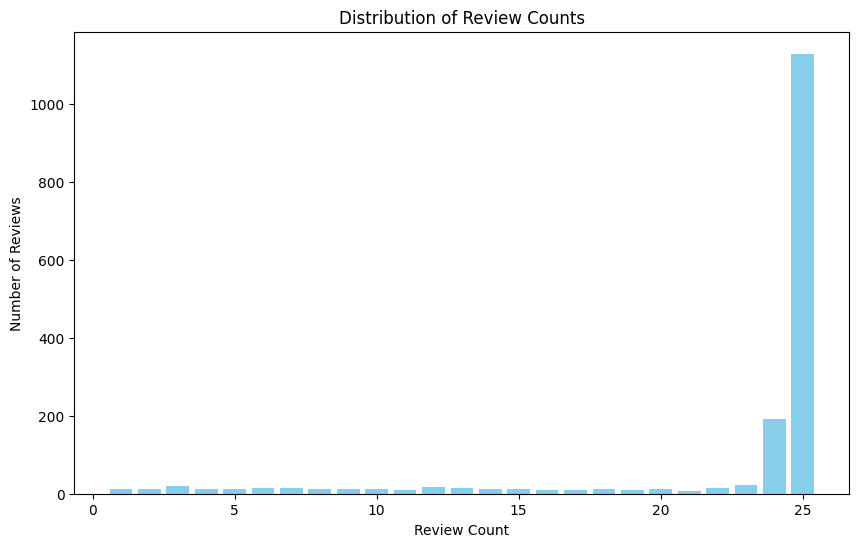

In [40]:
plt.figure(figsize=(10, 6))
plt.bar(temp_df['reviews_count'].value_counts().keys(), temp_df['reviews_count'].value_counts().values, color='skyblue')
plt.xlabel('Review Count')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Counts')
plt.show()

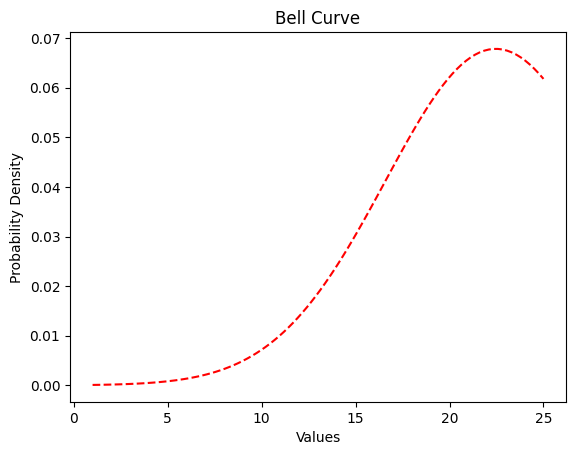

In [33]:
mu, sigma = np.mean(temp_df['reviews_count']), np.std(temp_df['reviews_count'])
x = np.linspace(1, 25, 100)         # 1 is the minimum review we can have for a review and 25 is the maximum we can have
plt.plot(x, norm.pdf(x, mu, sigma), 'r--')
plt.xlabel('Values')
plt.ylabel('Probability Density')
plt.title('Bell Curve')
plt.show()

Handling NaN values

In [41]:
data_db.fillna("{'content': ''}", inplace= True)

In [45]:
sentiment_df = pd.DataFrame()

# Create a SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment polarity
def get_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    return sentiment_score['compound']

# Applying sentiment analysis
for i in data_db.columns:
    sentiment_df[str(i)] = data_db[i].apply(get_sentiment)

# Display the DataFrame with sentiment scores
sentiment_df.head()

C:\Users\keera\AppData\Local\Temp\ipykernel_38452\461130154.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment_df[str(i)] = df[i].apply(get_sentiment)
C:\Users\keera\AppData\Local\Temp\ipykernel_38452\461130154.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sentiment_df[str(i)] = df[i].apply(get_sentiment)
C:\Users\keera\AppData\Local\Temp\ipykernel_38452\461130154.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Kika (1993),Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
0,0.9982,0.9666,0.9976,0.9908,0.9623,0.5665,0.9944,0.9992,-0.9231,0.9834,...,0.9174,0.9786,-0.9306,-0.1901,0.9951,0.9935,0.9871,0.8896,-0.7097,0.9312
1,0.9892,0.9974,0.9973,0.9897,0.9930,0.9834,0.9991,0.9940,-0.9950,0.9948,...,-0.9949,0.8825,0.9975,0.9902,-0.2597,0.9619,0.9961,-0.9113,0.9905,0.1145
2,0.9920,0.9745,0.9819,0.9518,0.9804,0.9973,-0.8418,0.9901,-0.9880,0.1989,...,0.8162,-0.9471,0.9982,0.9138,0.9906,0.8687,0.9913,0.8929,0.9437,0.9516
3,0.9989,-0.4943,0.9961,0.9981,-0.9613,0.9903,0.9941,0.9977,0.8001,0.9923,...,-0.7870,-0.5187,0.9770,0.9893,0.6715,0.8685,0.9643,0.9963,0.9946,0.3612
4,0.9900,0.9700,0.9738,0.9486,0.9179,0.9889,0.9411,0.9824,0.9820,0.9980,...,0.9961,-0.8545,-0.2481,0.9544,0.8999,0.9294,0.9786,0.9955,0.7196,0.1756


In [171]:
sentiment_df.to_csv('sentiment_movie_review.csv')

In [172]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Columns: 1614 entries, Toy Story (1995) to Scream of Stone (Schrei aus Stein) (1991)
dtypes: float64(1614)
memory usage: 315.4 KB


In [46]:
columns = sentiment_df.columns
compoundlist=[]
def abc(col):
    temp = col.loc[col != 0]
    compoundlist.append(np.array(temp).mean())

for column in columns:
    abc(sentiment_df[column])

In [47]:
compoundlist

[0.9799833333333333,
 0.465684,
 0.4975875,
 0.8623708333333333,
 0.0004960000000000075,
 0.7959440000000001,
 0.800332,
 0.9507119999999999,
 0.04369200000000001,
 0.443328,
 0.59162,
 0.9132640000000001,
 0.989575,
 0.9288319999999999,
 0.9288319999999999,
 0.400404,
 0.564696,
 0.621208,
 0.869048,
 0.91314,
 0.7834960000000001,
 0.100144,
 0.7136,
 0.938952,
 0.640575,
 0.5017920000000001,
 0.9409083333333333,
 0.5242800000000001,
 0.7341640000000001,
 0.31168,
 0.4871083333333333,
 0.6698080000000001,
 -0.1649347826086956,
 0.8816875,
 0.23216399999999995,
 -0.016539999999999996,
 0.520432,
 0.3373375,
 0.897972,
 0.45376399999999995,
 0.8739199999999999,
 0.5781879999999999,
 0.474456,
 0.966104,
 0.48625599999999997,
 0.9689279999999999,
 0.803056,
 0.9706679999999999,
 0.618,
 0.7556280000000001,
 0.4328639999999999,
 -0.38964800000000005,
 0.47560800000000003,
 0.524568,
 0.606848,
 0.5749559999999999,
 0.6844879999999999,
 0.9260600000000001,
 0.5648839999999999,
 0.651148000

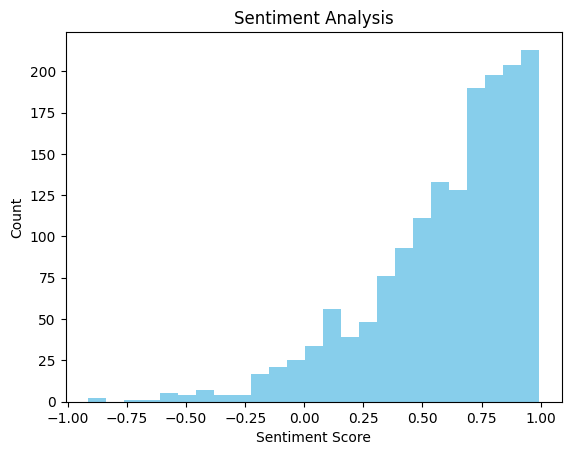

In [64]:
plt.hist(compoundlist, bins= 25, color= 'skyblue')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Sentiment Analysis')
plt.show()

In [54]:
min_indexing = compoundlist.index(np.array(compoundlist).min())
max_indexing = compoundlist.index(np.array(compoundlist).max())
print(f"Minimum review movie: {columns[min_indexing]}")
print(f"Maximum review movie: {columns[max_indexing]}")

Minimum review movie: Brother Minister: The Assassination of Malcolm X (1994)
Maximum review movie: Orlando (1993)


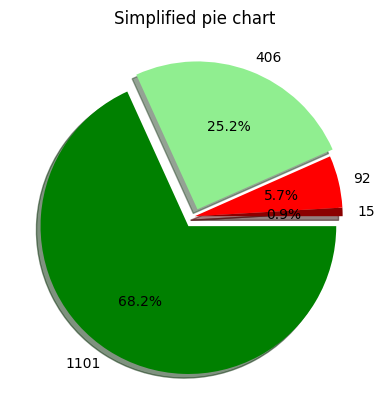

In [106]:
pie_chart_values = np.histogram(compoundlist, bins= 4)[0]
explode = [0, 0, 0.05 , 0.08]
colors = ['darkred', 'red', 'lightgreen', 'green']
plt.pie(pie_chart_values, explode= explode, autopct='%1.1f%%', startangle=0, shadow=True, colors=colors, labels=pie_chart_values)
plt.title('Simplified pie chart')
plt.show()

# 2. Collaborative filtering-based recommender system

In [3]:
data_db = pd.read_csv('u.data', sep= '\t', names=  ['user id', 'item id','rating', 'timestamp'])
data_db.drop(columns= ['timestamp'], inplace= True)
data_db.head()

,user id,item id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
# Create the user-item matrix
user_item_matrix = data_db.pivot(index='user id', columns='item id', values='rating')
user_item_matrix

item id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Fill NaN values with 0 (assuming missing values mean no rating)
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix

item id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
total_elements = user_item_matrix.size
zero_elements = np.count_nonzero(user_item_matrix == 0)
print("Sparsity Ratio:", zero_elements / total_elements)

Sparsity Ratio: 0.9369533063577546


# 3. Hybrid recommender system

## Preprocessing

In [207]:
data_db = pd.read_csv('u.data', sep= '\t', names=  ['User_Id', 'Movie_Id','Rating', 'timestamp'])
data_db.drop(columns= ['timestamp'], inplace= True)
data_db.shape

(100000, 3)

In [215]:
sentiment_df = pd.read_csv('sentiment_movie_review.csv')
sentiment_df.drop(columns= ['Unnamed: 0'], inplace = True)
sentiment_df = sentiment_df.transpose()

In [216]:
sentiment_df

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Toy Story (1995),0.9982,0.9892,0.9920,0.9989,0.9900,0.9916,0.9891,0.9151,0.9869,0.9981,...,0.9964,0.9976,0.9558,0.9617,0.9973,0.9828,0.9958,0.9764,0.9914,0.0000
GoldenEye (1995),0.9666,0.9974,0.9745,-0.4943,0.9700,0.9937,-0.9895,0.9555,-0.9794,0.9393,...,0.9108,0.9791,0.9939,0.8885,0.9623,0.9815,-0.9568,-0.8641,-0.8450,0.6143
Four Rooms (1995),0.9976,0.9973,0.9819,0.9961,0.9738,0.9522,0.9589,0.9829,0.8604,0.9439,...,-0.4883,0.9853,0.9200,0.9779,-0.9574,-0.2980,0.9505,0.9925,0.6050,0.0000
Get Shorty (1995),0.9908,0.9897,0.9518,0.9981,0.9486,0.9965,-0.2098,0.9965,0.9958,0.9991,...,0.9423,0.9974,0.9932,0.9964,0.9698,-0.7159,0.9975,0.0000,0.9524,0.9620
Copycat (1995),0.9623,0.9930,0.9804,-0.9613,0.9179,0.9949,0.8495,-0.9777,0.0471,-0.9853,...,0.9482,-0.4551,-0.9098,-0.9722,0.9828,-0.9979,0.9439,-0.4215,0.9911,0.9635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sweet Nothing (1995),0.9935,0.9619,0.8687,0.8685,0.9294,-0.4436,-0.7569,0.9604,-0.9226,0.9699,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mat' i syn (1997),0.9871,0.9961,0.9913,0.9643,0.9786,-0.0900,0.9873,0.9831,0.8488,0.9422,...,-0.8382,0.6920,0.4813,-0.8432,0.9136,0.9963,0.9588,-0.2477,0.9482,0.9835
B. Monkey (1998),0.8896,-0.9113,0.8929,0.9963,0.9955,0.8924,0.9834,-0.9509,0.9973,0.9921,...,0.9986,0.9913,0.5403,0.8860,0.9163,0.0000,-0.7436,0.9122,-0.9928,0.0000
You So Crazy (1994),-0.7097,0.9905,0.9437,0.9946,0.7196,0.9683,0.9806,-0.9121,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [217]:
columns = sentiment_df.index
temp_df = pd.DataFrame()
item_df = pd.read_csv('u.item', sep= '|', header= None)
item_df.shape

(1682, 24)

In [218]:
item_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [219]:
# Removing duplicates movie name
item_df.drop_duplicates(subset=1, keep='first', inplace=True)
item_df.shape

(1664, 24)

In [220]:
# Only selecting those values for our item_df which have movie name in our sentiment db
item_df = item_df[item_df[1].isin(columns)]

In [221]:
sentiment_df.shape

(1614, 25)

In [222]:
item_df.shape

(1606, 24)

In [223]:
from collections import Counter

test = item_df[1].values

counter1 = Counter(columns)
counter2 = Counter(test)

dublicate_values = list((counter1 - counter2).elements())
print(dublicate_values)
print(len(dublicate_values))

['Misï¿½rables, Les (1995)', 'Double vie de Vï¿½ronique, La (Double Life of Veronique, The) (1991)', "C'est arrivï¿½ prï¿½s de chez vous (1992)", 'Nï¿½nette et Boni (1996)', 'Metisse (Cafï¿½ au Lait) (1993)', 'JLG/JLG - autoportrait de dï¿½cembre (1994)', 'Cï¿½rï¿½monie, La (1995)', 'ï¿½ kï¿½ldum klaka (Cold Fever) (1994)']
8


In [224]:
# Removing incorrect data from our sentiment database
sentiment_df.drop(dublicate_values, inplace = True)
sentiment_df.shape

(1606, 25)

In [225]:
item_df.to_csv('updated_item.csv')
sentiment_df.to_csv('updated_sentiment.csv')

In [257]:
item_df = pd.read_csv('updated_item.csv')
sentiment_df = pd.read_csv('updated_sentiment.csv')
item_df.drop(columns= ['Unnamed: 0'], inplace = True)
sentiment_df.drop(columns= ['Unnamed: 0'], inplace = True)

In [258]:
item_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [95]:
concatenated_data = pd.concat([item_df, sentiment_df], axis= 1)
concatenated_data.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0.9964,0.9976,0.9558,0.9617,0.9973,0.9828,0.9958,0.9764,0.9914,0.0000
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0.9108,0.9791,0.9939,0.8885,0.9623,0.9815,-0.9568,-0.8641,-0.8450,0.6143
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,-0.4883,0.9853,0.9200,0.9779,-0.9574,-0.2980,0.9505,0.9925,0.6050,0.0000
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0.9423,0.9974,0.9932,0.9964,0.9698,-0.7159,0.9975,0.0000,0.9524,0.9620
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0.9482,-0.4551,-0.9098,-0.9722,0.9828,-0.9979,0.9439,-0.4215,0.9911,0.9635


In [100]:
pd_genre = pd.read_csv('u.genre', sep= '|', header= None)
pd_genre.loc[pd_genre[0] == 'unknown', 0] = 'Unknown'
columns = ['Movie_Id', 'Movie_Title', 'Release_Date', 'Video_Release_Date', 'IMDB_Url'] + pd_genre[0].to_list() + [f'Review {i+1}' for i in range(25)]
concatenated_data.columns = columns
concatenated_data.head()

,Movie_Id,Movie_Title,Release_Date,Video_Release_Date,IMDB_Url,Unknown,Action,Adventure,Animation,Children's,...,Review 16,Review 17,Review 18,Review 19,Review 20,Review 21,Review 22,Review 23,Review 24,Review 25
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0.9964,0.9976,0.9558,0.9617,0.9973,0.9828,0.9958,0.9764,0.9914,0.0000
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0.9108,0.9791,0.9939,0.8885,0.9623,0.9815,-0.9568,-0.8641,-0.8450,0.6143
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,-0.4883,0.9853,0.9200,0.9779,-0.9574,-0.2980,0.9505,0.9925,0.6050,0.0000
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0.9423,0.9974,0.9932,0.9964,0.9698,-0.7159,0.9975,0.0000,0.9524,0.9620
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0.9482,-0.4551,-0.9098,-0.9722,0.9828,-0.9979,0.9439,-0.4215,0.9911,0.9635


In [101]:
# Cleaning data
concatenated_data.drop(columns= ['Movie_Title', 'Release_Date', 'Video_Release_Date', 'IMDB_Url'], inplace = True)

In [102]:
# Saving
concatenated_data.to_csv('Concatenated_data.csv')

In [209]:
# Loading our concatenated data
concatenated_data = pd.read_csv('Concatenated_data.csv')
concatenated_data.drop(columns= ['Unnamed: 0'], inplace= True)
concatenated_data.shape

(1606, 45)

In [213]:
data_db = data_db[data_db['Movie_Id'].isin(concatenated_data['Movie_Id'])]
data_db.shape

(96700, 3)

In [255]:
data_db.head()

,User_Id,Movie_Id,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [254]:
concatenated_data.head()

,Movie_Id,Unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,...,Review 16,Review 17,Review 18,Review 19,Review 20,Review 21,Review 22,Review 23,Review 24,Review 25
0,1,0,0,0,1,1,1,0,0,0,...,0.9964,0.9976,0.9558,0.9617,0.9973,0.9828,0.9958,0.9764,0.9914,0.0000
1,2,0,1,1,0,0,0,0,0,0,...,0.9108,0.9791,0.9939,0.8885,0.9623,0.9815,-0.9568,-0.8641,-0.8450,0.6143
2,3,0,0,0,0,0,0,0,0,0,...,-0.4883,0.9853,0.9200,0.9779,-0.9574,-0.2980,0.9505,0.9925,0.6050,0.0000
3,4,0,1,0,0,0,1,0,0,1,...,0.9423,0.9974,0.9932,0.9964,0.9698,-0.7159,0.9975,0.0000,0.9524,0.9620
4,5,0,0,0,0,0,0,1,0,1,...,0.9482,-0.4551,-0.9098,-0.9722,0.9828,-0.9979,0.9439,-0.4215,0.9911,0.9635


In [253]:
main_db = merged_df = pd.merge(data_db, concatenated_data, on='Movie_Id')
main_db.head()

,User_Id,Movie_Id,Rating,Unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Review 16,Review 17,Review 18,Review 19,Review 20,Review 21,Review 22,Review 23,Review 24,Review 25
0,196,242,3,0,0,0,0,0,1,0,...,0.8779,0.8781,0.9721,0.8516,0.9636,0.9659,0.9711,0.9802,0.9804,0.9364
1,63,242,3,0,0,0,0,0,1,0,...,0.8779,0.8781,0.9721,0.8516,0.9636,0.9659,0.9711,0.9802,0.9804,0.9364
2,226,242,5,0,0,0,0,0,1,0,...,0.8779,0.8781,0.9721,0.8516,0.9636,0.9659,0.9711,0.9802,0.9804,0.9364
3,154,242,3,0,0,0,0,0,1,0,...,0.8779,0.8781,0.9721,0.8516,0.9636,0.9659,0.9711,0.9802,0.9804,0.9364
4,306,242,5,0,0,0,0,0,1,0,...,0.8779,0.8781,0.9721,0.8516,0.9636,0.9659,0.9711,0.9802,0.9804,0.9364


In [249]:
main_db.to_csv('Main_3.csv')

## Recommender

In [30]:
main_db = pd.read_csv('Main_3.csv')
main_db.drop(columns = ['Unnamed: 0'], inplace= True)
print(main_db.head())
print(main_db.shape)

   User_Id  Movie_Id  Rating  Unknown  Action  Adventure  Animation  \
0      196       242       3        0       0          0          0   
1       63       242       3        0       0          0          0   
2      226       242       5        0       0          0          0   
3      154       242       3        0       0          0          0   
4      306       242       5        0       0          0          0   

   Children's  Comedy  Crime  ...  Review 16  Review 17  Review 18  Review 19  \
0           0       1      0  ...     0.8779     0.8781     0.9721     0.8516   
1           0       1      0  ...     0.8779     0.8781     0.9721     0.8516   
2           0       1      0  ...     0.8779     0.8781     0.9721     0.8516   
3           0       1      0  ...     0.8779     0.8781     0.9721     0.8516   
4           0       1      0  ...     0.8779     0.8781     0.9721     0.8516   

   Review 20  Review 21  Review 22  Review 23  Review 24  Review 25  
0     0.9636    

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split

In [60]:
# Assuming your dataframe is named 'df'
train_data, test_data = train_test_split(main_db, test_size= SPLIT, random_state=42)

# Define a PyTorch Dataset
class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return user_id, movie_id, and rating as tensors
        return torch.LongTensor([self.data.iloc[idx]['User_Id'],
                                 self.data.iloc[idx]['Movie_Id']]), \
               torch.FloatTensor([self.data.iloc[idx]['Rating']])

# Create DataLoader instances for training and testing
train_dataset = MovieDataset(train_data)
test_dataset = MovieDataset(test_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [79]:
class HybridRecommender(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim):
        super(HybridRecommender, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, 1)

    def forward(self, user_movie):
        user_embedded = self.user_embedding(user_movie[:, 0])
        movie_embedded = self.movie_embedding(user_movie[:, 1])
        concatenated = torch.cat([user_embedded, movie_embedded], dim=1)
        output = self.fc(concatenated).squeeze()
        return output

In [80]:
max_user_id = main_db['User_Id'].max()
max_movie_id = main_db['Movie_Id'].max()

print(f'Max User ID: {max_user_id}, Max Movie ID: {max_movie_id}')


Max User ID: 943, Max Movie ID: 1682


In [81]:
# Instantiate the model
model = HybridRecommender(num_users=max_user_id + 1,  # Add 1 to include the maximum ID
                          num_movies=max_movie_id + 1,
                          embedding_dim=64)  # Adjust the size as needed

In [82]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    for user_movie, rating in train_loader:
        optimizer.zero_grad()
        output = model(user_movie)
        loss = criterion(output, rating)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/30, Loss: 1.705293893814087
Epoch 2/30, Loss: 1.0444920063018799
Epoch 3/30, Loss: 1.7748972177505493
Epoch 4/30, Loss: 0.9053320288658142
Epoch 5/30, Loss: 0.9204771518707275
Epoch 6/30, Loss: 1.1334624290466309
Epoch 7/30, Loss: 1.1738146543502808
Epoch 8/30, Loss: 1.4628095626831055
Epoch 9/30, Loss: 1.1700494289398193
Epoch 10/30, Loss: 1.4197227954864502
Epoch 11/30, Loss: 0.9267003536224365
Epoch 12/30, Loss: 1.2491950988769531
Epoch 13/30, Loss: 1.1811106204986572
Epoch 14/30, Loss: 1.0457650423049927
Epoch 15/30, Loss: 1.169919490814209
Epoch 16/30, Loss: 1.00336492061615
Epoch 17/30, Loss: 1.1170371770858765
Epoch 18/30, Loss: 1.3753458261489868
Epoch 19/30, Loss: 1.3942266702651978
Epoch 20/30, Loss: 1.093781590461731
Epoch 21/30, Loss: 1.2226409912109375
Epoch 22/30, Loss: 1.2963937520980835
Epoch 23/30, Loss: 1.332917332649231
Epoch 24/30, Loss: 1.4219679832458496
Epoch 25/30, Loss: 1.130080223083496
Epoch 26/30, Loss: 0.9475735425949097
Epoch 27/30, Loss: 0.9629162

In [83]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for user_movie, rating in test_loader:
        output = model(user_movie)
        test_loss += criterion(output, rating).item()

    avg_test_loss = test_loss / len(test_loader)
    print(f'Average Test Loss: {avg_test_loss}')

Average Test Loss: 1.3048900056986918


d:\College\Social Media\Project\.venv\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [84]:
# Assuming the model is trained, let's make recommendations for a user (e.g., user_id = 196)
user_id_to_recommend = 196

# Get movies that the user has not rated
movies_not_rated = main_db.loc[~main_db['Movie_Id'].isin(main_db[main_db['User_Id'] == user_id_to_recommend]['Movie_Id'])]['Movie_Id'].unique()

# Create input tensor for the user and all unrated movies
user_movie_input = torch.LongTensor([[user_id_to_recommend, movie_id] for movie_id in movies_not_rated])

# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(user_movie_input).numpy()

# Combine movie IDs with their predicted ratings
recommendations = pd.DataFrame({'Movie_Id': movies_not_rated, 'Predicted_Rating': predictions})

# Get the top N recommendations
top_recommendations = recommendations.nlargest(5, 'Predicted_Rating')

# Display top recommendations
print(f"Top Recommendations for User {user_id_to_recommend}:\n")
for idx, row in top_recommendations.iterrows():
    movie_id = int(row['Movie_Id'])
    predicted_rating = row['Predicted_Rating']
    print(f"Movie ID: {movie_id}, Predicted Rating: {predicted_rating}")

Top Recommendations for User 196:

Movie ID: 1353, Predicted Rating: 3.6118624210357666
Movie ID: 621, Predicted Rating: 3.6110596656799316
Movie ID: 1214, Predicted Rating: 3.604921817779541
Movie ID: 992, Predicted Rating: 3.5923047065734863
Movie ID: 1355, Predicted Rating: 3.5919227600097656
